<a href="https://colab.research.google.com/github/scmprune/Algorithm-Zeroth-Order/blob/main/algo_ZO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def function(N=2000, d=100, x_star_val=2.0):

    x_star = np.full(d, x_star_val)
    a = np.tile(x_star, (N, 1))

    def F(x):
        return np.sum(np.abs(x - a) ** 2) / N

    def g_i_center(x, i, mu, q=1):
        grad = np.zeros_like(x)
        for _ in range(q):
            u = np.random.randn(d)
            u /= np.linalg.norm(u)
            f_plus = np.sum((x + mu * u - a[i]) ** 2)
            f_minus = np.sum((x - mu * u - a[i]) ** 2)
            grad += d * (f_plus - f_minus) * u / (2 * mu)
        return grad / q



    def g_i(x, i, mu):
        u = np.random.randn(d)
        u /= np.linalg.norm(u)
        fi_plus = np.sum((x + mu * u - a[i]) ** 2)
        fi = np.sum((x - a[i]) ** 2)
        return d * (fi_plus - fi) * u / mu


    def g_i_center_avg(x, i, mu, q):
        grad = np.zeros_like(x)
        for _ in range(q):
            u = np.random.randn(len(x))
            u /= np.linalg.norm(u)

            fi_plus = np.sum((x + mu * u - a[i]) ** 2)
            fi_minus = np.sum((x - mu * u - a[i]) ** 2)

            grad += d * (fi_plus - fi_minus) * u / (q * mu)

        return grad / q


    def gradF(x, v):
        return 2 * np.sum(x - a[v], axis=0) / len(v)

    return F, g_i, g_i_center,g_i_center_avg, gradF, N, a, d, x_star


$\delta$ dans mon code n'est pas le même que celui utilisé pour la preuve

In [3]:
F, g_i, g_i_center,g_i_center_avg, gradF, N, a, d, x_star = function()

def ZO_SGD(T,gamma,delta,X0,m):
    liste = np.zeros((T, d))
    value_f = np.zeros(T)
    value_grad = np.zeros(T)

    x0 = X0.copy()
    for t in range(T):
        v = np.random.choice(N,m,replace=False)
        grad_sum = np.zeros(d)

        mu0= np.exp(-delta * t)

        for i in v:
            grad_sum += g_i(x0, i, mu0)


        x0 -= gamma * grad_sum / m


        liste[t, :] = x0
        value_f[t] = F(x0)
        value_grad[t] = np.linalg.norm(grad_sum)

    return liste,value_f,value_grad

def ZO_SGD_center(T,gamma,delta,X0,m):
    liste = np.zeros((T, d))
    value_f = np.zeros(T)
    value_grad = np.zeros(T)

    x0 = X0.copy()
    for t in range(T):
        v = np.random.choice(N,m,replace=False)
        grad_sum = np.zeros(d)

        mu0= np.exp(-delta * t)

        for i in v:
            grad_sum += g_i_center(x0, i, mu0)

        x0 -= gamma * grad_sum / m

        liste[t, :] = x0
        value_f[t] = F(x0)
        value_grad[t] = np.linalg.norm(grad_sum)
    return liste,value_f,value_grad


def ZO_SGD_avg(T,gamma,delta,X0,m,q):
    liste = np.zeros((T, d))
    value_f = np.zeros(T)
    value_grad = np.zeros(T)

    x0 = X0.copy()
    for t in range(T):
        v = np.random.choice(N,m,replace=False)
        grad_sum = np.zeros(d)


        mu0= np.exp(-delta * t)

        for i in v:
            grad_sum += g_i_center_avg(x0, i, mu0, q)


        x0 -= gamma * grad_sum / m


        liste[t, :] = x0
        value_f[t] = F(x0)
        value_grad[t] = np.linalg.norm(grad_sum)

    return liste,value_f,value_grad


def SVRG(T,gamma,X0,m, p):

    liste = np.zeros((T, d))
    value_f = np.zeros(T)
    value_grad = np.zeros(T)

    w0 = X0
    G= gradF(w0, np.arange(N))

    for k in range(T):

        v = np.random.choice(N,m,replace=False)
        y = gradF(X0,v)
        z = gradF(w0, v)
        g1 = G + y - z
        X0 -= gamma * g1

        proba = np.random.rand()

        if proba < p :

            w0 = X0
            G = gradF(w0, np.arange(N))


        liste[k, :] = X0
        value_f[k] = F(X0)
        value_grad[k] = np.linalg.norm(g1)

    return liste,value_f,value_grad

On regarde ici l'impact de $\delta$ sur la convergence de l'algo

In [4]:
deltas = [
    0.001, 0.0002, 0.0005,
    0.001, 0.002, 0.005,
    0.007, 0.01, 0.015, 0.02,
    0.03, 0.05, 0.07,
]


results = np.zeros((1, 1, len(deltas)))
all_vf = {}

m = 10
gamma = 0.005
K = 4000

for k, delta in enumerate(deltas):
    x0 = np.zeros(d)
    vect, vf, vg = ZO_SGD(K, gamma, delta, x0, m)
    key = f"δ={delta}"
    all_vf[key] = vf,vg


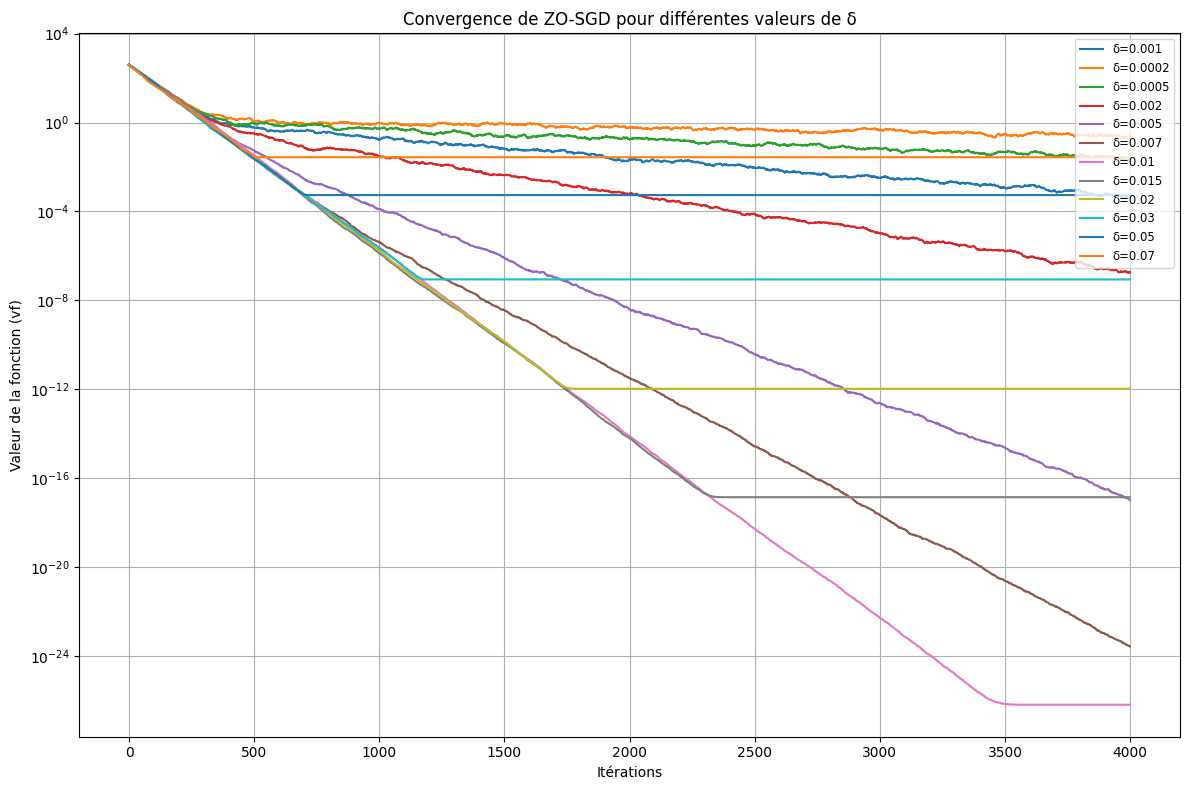

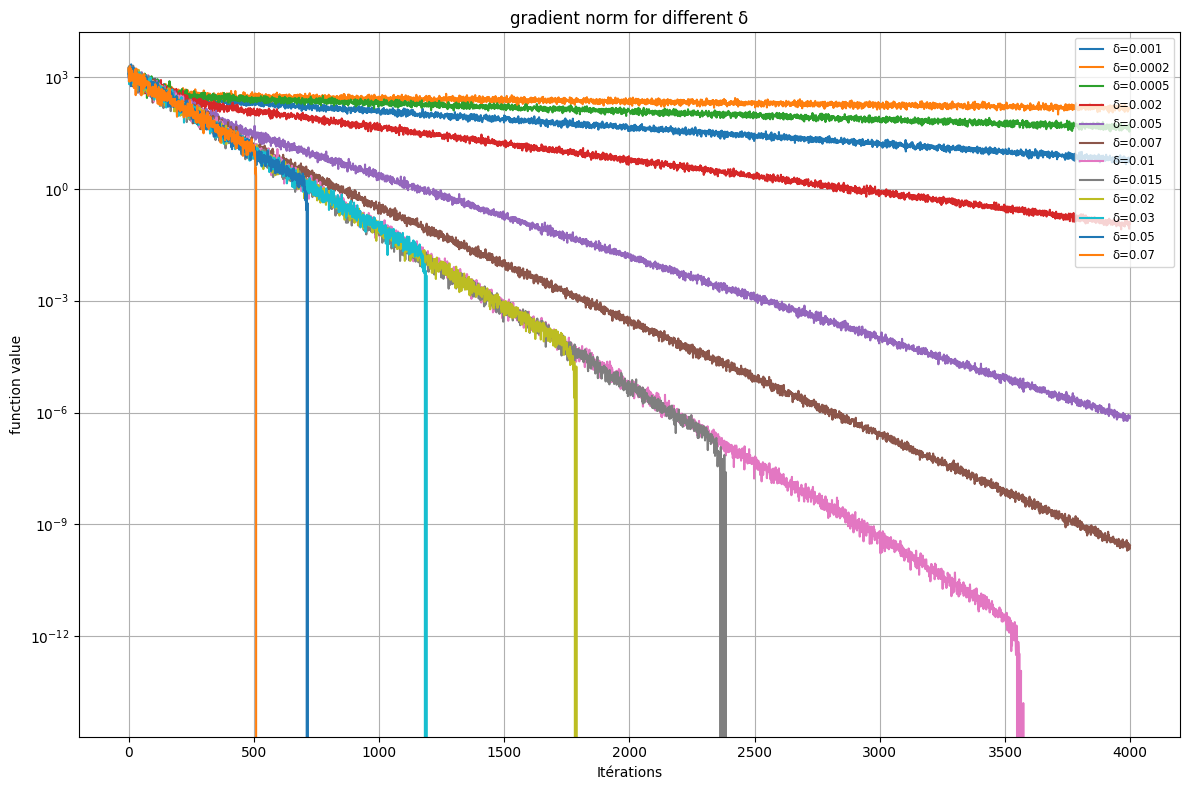

In [5]:
plt.figure(figsize=(12, 8))

for key, (vf, _) in all_vf.items():
    plt.plot(vf, label=key)

plt.title("Convergence de ZO-SGD pour différentes valeurs de δ")
plt.xlabel("Itérations")
plt.ylabel("Valeur de la fonction (vf)")
plt.legend(loc="upper right", fontsize="small")
plt.grid(True)
plt.yscale('log')
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 8))

for key, (_, vg) in all_vf.items():
    plt.plot(vg, label=key)

plt.title("gradient norm for different δ")
plt.xlabel("Itérations")
plt.ylabel("function value")
plt.legend(loc="upper right", fontsize="small")
plt.grid(True)
plt.yscale('log')
plt.tight_layout()
plt.show()

on voit que $\delta$ influe sur la vitesse de convergence, mais un trop grand $\delta$ induit une trop grosse instabilité numérique quand on fait un trop gros nombre d'itération

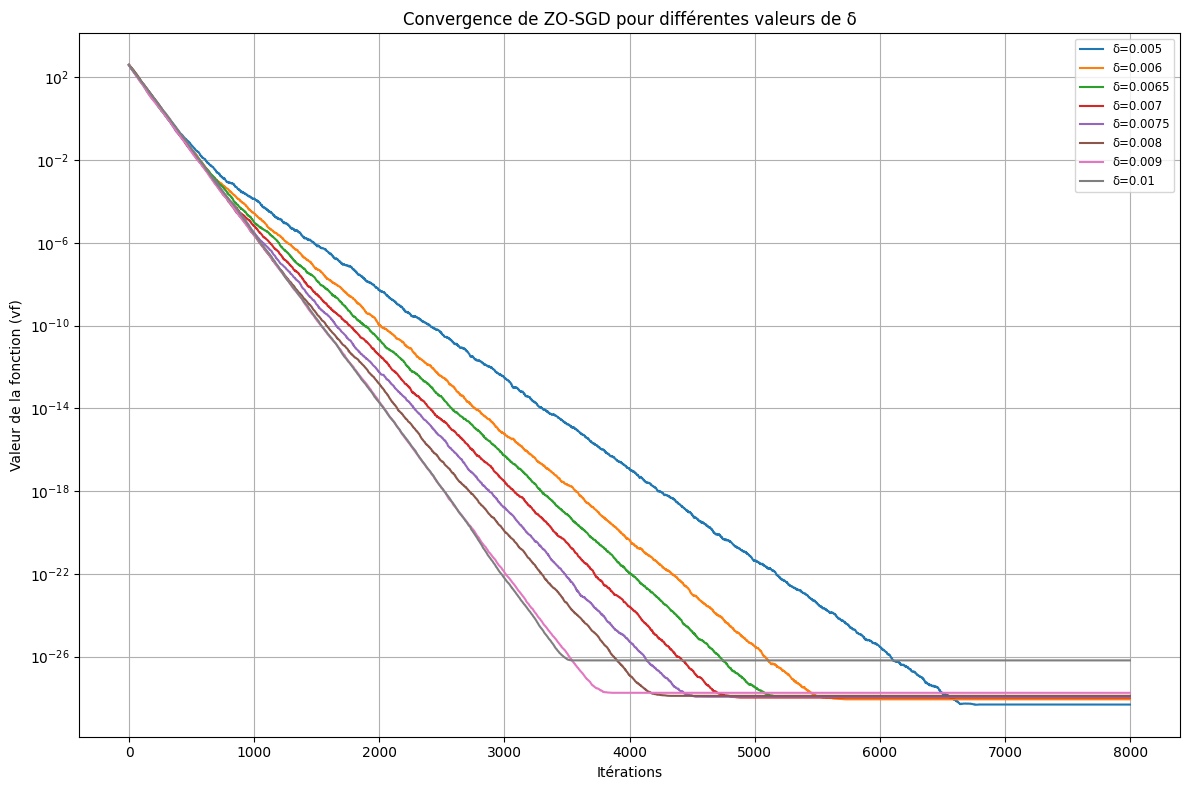

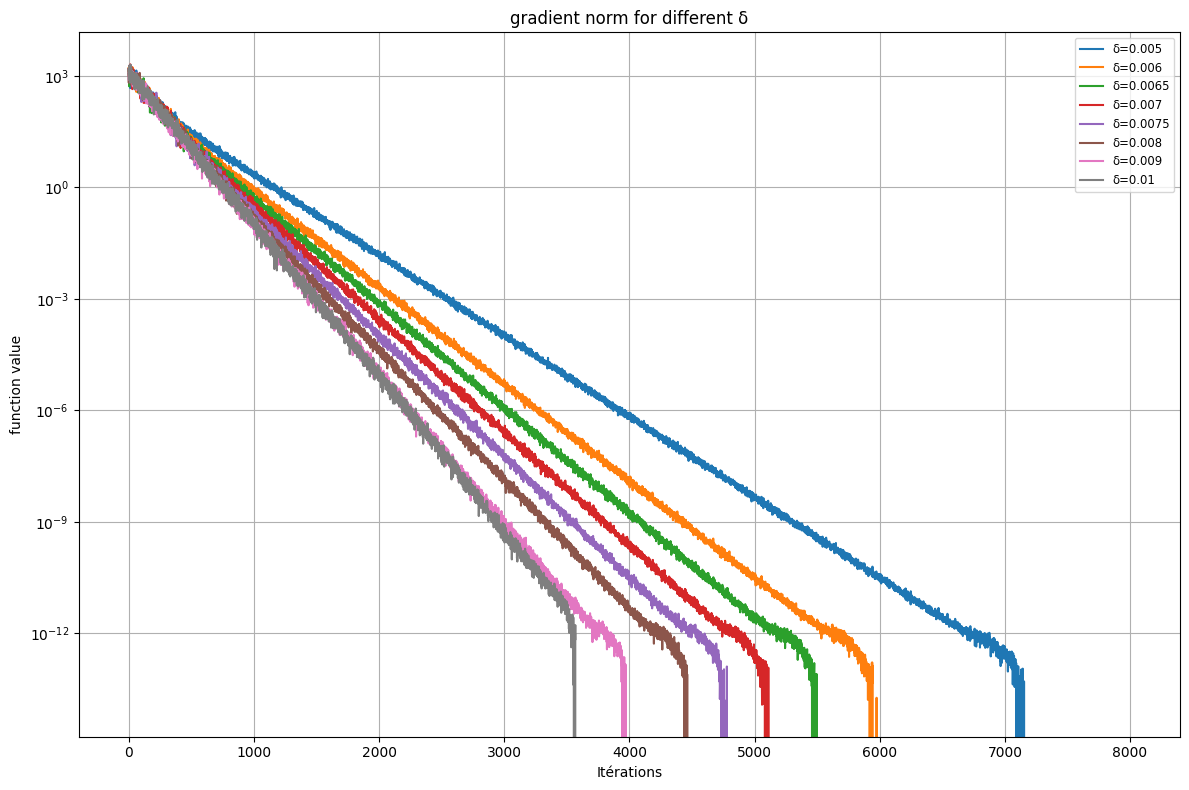

In [6]:
deltas_focus = [0.005, 0.006, 0.0065, 0.007, 0.0075, 0.008, 0.009, 0.01]
results = np.zeros((1, 1, len(deltas)))
all_vf = {}

m = 10
gamma = 0.005
K = 8000

for k, delta in enumerate(deltas_focus):
    x0 = np.zeros(d)
    vect, vf, vg = ZO_SGD(K, gamma, delta, x0, m)
    key = f"δ={delta}"
    all_vf[key] = vf,vg


plt.figure(figsize=(12, 8))

for key, (vf, _) in all_vf.items():
    plt.plot(vf, label=key)

plt.title("Convergence de ZO-SGD pour différentes valeurs de δ")
plt.xlabel("Itérations")
plt.ylabel("Valeur de la fonction (vf)")
plt.legend(loc="upper right", fontsize="small")
plt.grid(True)
plt.yscale('log')
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 8))

for key, (_, vg) in all_vf.items():
    plt.plot(vg, label=key)

plt.title("gradient norm for different δ")
plt.xlabel("Itérations")
plt.ylabel("function value")
plt.legend(loc="upper right", fontsize="small")
plt.grid(True)
plt.yscale('log')
plt.tight_layout()
plt.show()

On a quand même une plus grande précision du résultat quand $\delta$ est petit, mais au plus d'un plus grand nombre d'itérations.

In [7]:
K=4000
m= 10
delta= 0.005
alpha= 2

beta= L = 2

def gamma_max(alpha, beta, L, d, N, m):
    den = 2 * d * (beta * (N - m) + L * N * (m - 1)) / (m * (N - 1))
    return alpha / den
gamma = 0.5 * gamma_max(alpha, beta, L, d, N, m)
print(gamma)
p=0.3
x0 = np.zeros(d)

vect, vf, vg = ZO_SGD(K, gamma, delta, x0, m,)

v,vf_center,vg_center = ZO_SGD_center(K, gamma, delta, x0, m)

v_avg,vf_avg,vg_avg = ZO_SGD_avg(K, gamma, delta, x0, m,30)

0.0025


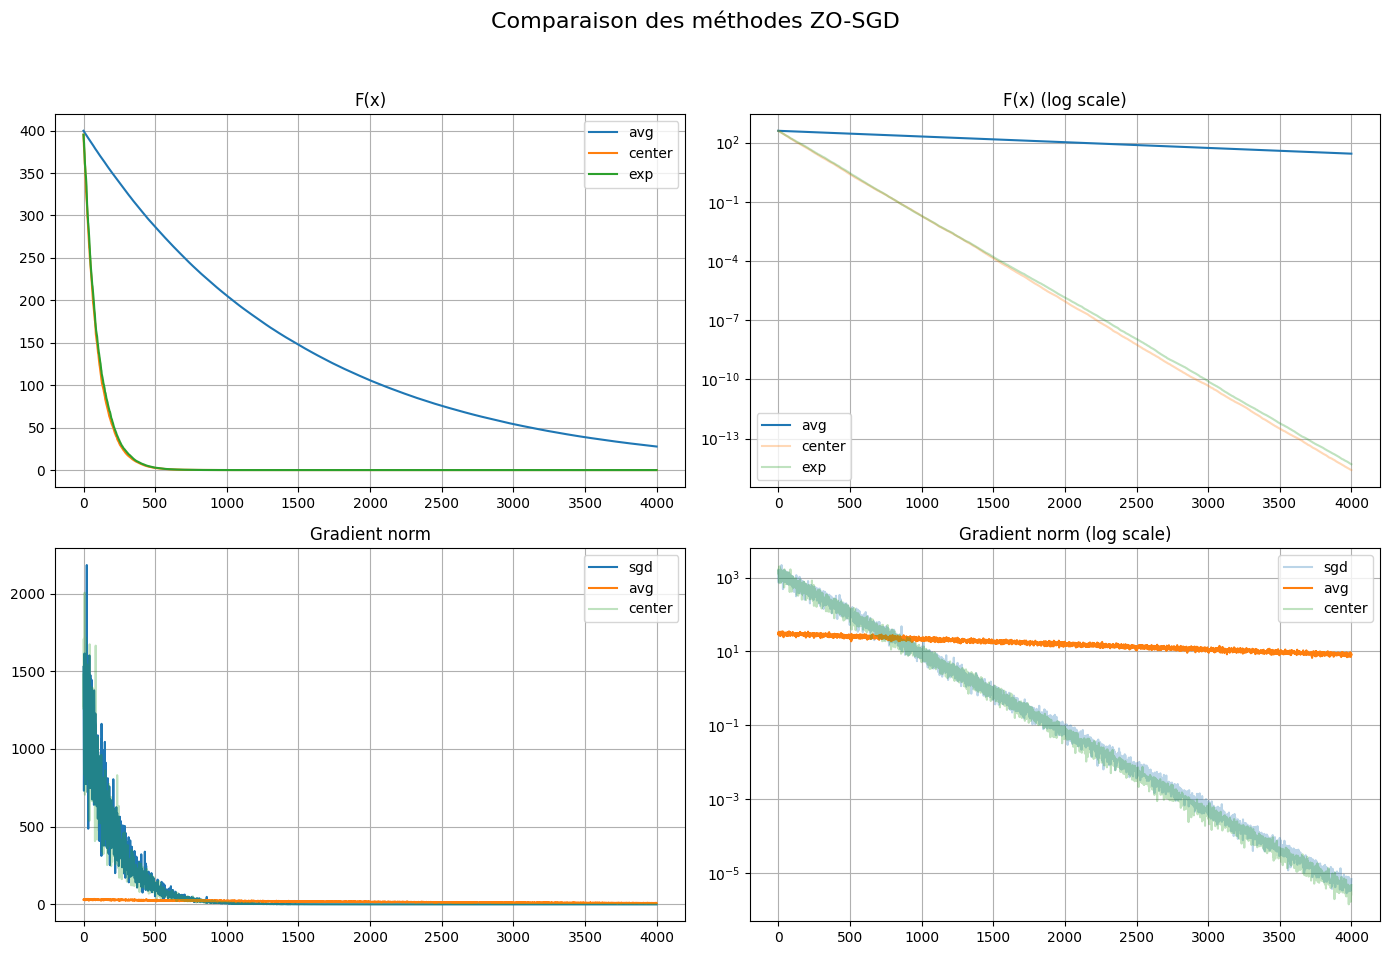

Erreur dernière itération       : 0.000000
Erreur moyenne derniers 3/4     : 0.009740
Erreur moyenne sur toutes       : 1.005299


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Comparaison des méthodes ZO-SGD', fontsize=16)

# Plot 1 — F(x)
axes[0, 0].set_title('F(x)')
axes[0, 0].plot(vf_avg, label='avg')
axes[0, 0].plot(vf_center, label='center')
axes[0, 0].plot(vf, label='exp')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot 2 — F(x) en log
axes[0, 1].set_title('F(x) (log scale)')
axes[0, 1].plot(vf_avg, label='avg')
axes[0, 1].plot(vf_center, label='center',alpha=0.3)
axes[0, 1].plot(vf, label='exp',alpha=0.3)
axes[0, 1].set_yscale('log')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot 3 — ||grad||
axes[1, 0].set_title('Gradient norm')
axes[1, 0].plot(vg, label='sgd')
axes[1, 0].plot(vg_avg, label='avg')
axes[1, 0].plot(vg_center, label='center',alpha=0.3)
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot 4 — ||grad|| en log
axes[1, 1].set_title('Gradient norm (log scale)')
axes[1, 1].plot(vg, label='sgd',alpha=0.3)
axes[1, 1].plot(vg_avg, label='avg')
axes[1, 1].plot(vg_center, label='center',alpha=0.3)
axes[1, 1].set_yscale('log')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# 1. Optimum théorique (moyenne des a_i)
x_star = np.mean(a, axis=0)

# 2. Dernière itération
x_last = vect[-1]
error_last = np.linalg.norm(x_last - x_star)

# 3. Moyenne des 3/4 dernières itérations
x_mean_last_3q = np.mean(vect[int(len(vect) * 0.25):], axis=0)
error_mean_last_3q = np.linalg.norm(x_mean_last_3q - x_star)

# 4. Moyenne de toutes les itérations
x_mean_all = np.mean(vect, axis=0)
error_mean_all = np.linalg.norm(x_mean_all - x_star)

# 5. Affichage
print(f"Erreur dernière itération       : {error_last:.6f}")
print(f"Erreur moyenne derniers 3/4     : {error_mean_last_3q:.6f}")
print(f"Erreur moyenne sur toutes       : {error_mean_all:.6f}")


In [9]:
K=2000
m= 10
x0 = np.zeros(d)

gamma = 0.5 * gamma_max(alpha, beta, L, d, N, m)
delta=gamma
p=0.3

vect, vf, vg = ZO_SGD(K, gamma, delta, x0, m)
vect_sgd,vf_sgd,vg_sgd = SVRG(K,gamma,x0,m,p)

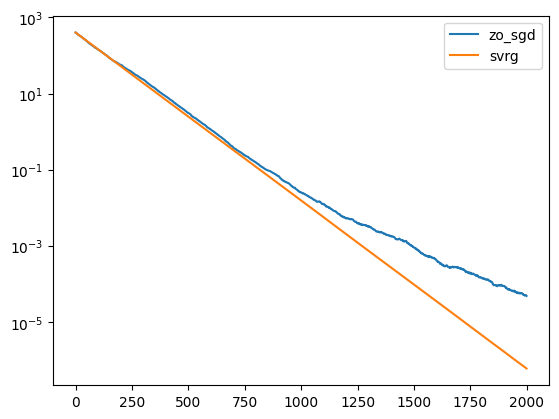

In [10]:
plt.plot(vf,label='zo_sgd')
plt.plot(vf_sgd,label='svrg')
plt.yscale('log')
plt.legend()

In [11]:
delta = 0.005
K=2000
m= 50
x0 = np.zeros(d)

gamma = 0.5 * gamma_max(alpha, beta, L, d, N, m)

p=0.3

vect, vf, vg = ZO_SGD(K, gamma, delta, x0, m)
vect_sgd,vf_sgd,vg_sgd = SVRG(K,gamma,x0,m,p)

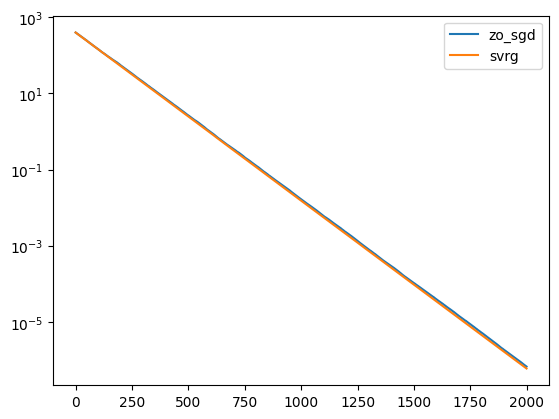

In [12]:
plt.plot(vf,label='zo_sgd')
plt.plot(vf_sgd,label='svrg')
plt.yscale('log')
plt.legend()

### Increase dimension

In [13]:
F, g_i, g_i_center,g_i_center_avg, gradF, N, a, d, x_star = function(d=1000)

In [14]:

def ZO_SGD(T,gamma,delta,X0,m):
    liste = np.zeros((T, d))
    value_f = np.zeros(T)
    value_grad = np.zeros(T)

    x0 = X0.copy()
    for t in range(T):
        v = np.random.choice(N,m,replace=False)
        grad_sum = np.zeros(d)

        # mu0 = np.exp(-(delta * t))
        mu0= np.sqrt(d) *np.exp(-delta * t)

        for i in v:
            grad_sum += g_i(x0, i, mu0)


        x0 -= gamma * grad_sum / m


        liste[t, :] = x0
        value_f[t] = F(x0)
        value_grad[t] = np.linalg.norm(grad_sum)
    return liste,value_f,value_grad

def ZO_SGD_center(T,gamma,delta,X0,m):
    liste = np.zeros((T, d))
    value_f = np.zeros(T)
    value_grad = np.zeros(T)

    x0 = X0.copy()
    for t in range(T):
        v = np.random.choice(N,m,replace=False)
        grad_sum = np.zeros(d)

        # mu0 = np.exp(-(delta * t))
        mu0= np.exp(-delta * t)

        for i in v:
            grad_sum += g_i_center(x0, i, mu0)


        x0 -= gamma * grad_sum / m


        liste[t, :] = x0
        value_f[t] = F(x0)
        value_grad[t] = np.linalg.norm(grad_sum)
    return liste,value_f,value_grad


def ZO_SGD_avg(T,gamma,delta,X0,m,q):
    liste = np.zeros((T, d))
    value_f = np.zeros(T)
    value_grad = np.zeros(T)

    x0 = X0.copy()
    for t in range(T):
        v = np.random.choice(N,m,replace=False)
        grad_sum = np.zeros(d)

        # mu0 = np.exp(-(delta * t))
        mu0= np.exp(-delta * t)

        for i in v:
            grad_sum += g_i_center_avg(x0, i, mu0, q)


        x0 -= gamma * grad_sum / m


        liste[t, :] = x0
        value_f[t] = F(x0)
        value_grad[t] = np.linalg.norm(grad_sum)
    return liste,value_f,value_grad


def SVRG(T,gamma,X0,m, p):

    liste = np.zeros((T, d))
    value_f = np.zeros(T)
    value_grad = np.zeros(T)

    w0 = X0
    G= gradF(w0, np.arange(N))

    for k in range(T):

        v = np.random.choice(N,m,replace=False)
        y = gradF(X0,v)
        z = gradF(w0, v)
        g1 = G + y - z
        X0 -= gamma * g1

        proba = np.random.rand()

        if proba < p :

            w0 = X0
            G = gradF(w0, np.arange(N))


        liste[k, :] = X0
        value_f[k] = F(X0)
        value_grad[k] = np.linalg.norm(g1)

    return liste,value_f,value_grad

In [15]:
delta = 0.001
K=10000
m= 10
x0 = np.zeros(d)

gamma = 0.5 * gamma_max(alpha, beta, L, d, N, m)

p=0.3

vect, vf, vg = ZO_SGD(K, gamma, delta, x0, m)
vect_sgd,vf_sgd,vg_sgd = SVRG(K,gamma,x0,m,p)

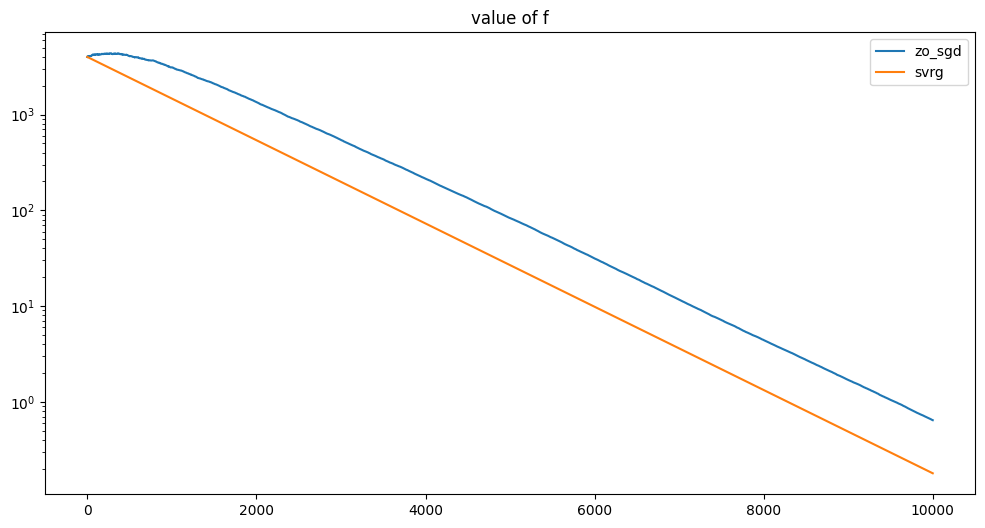

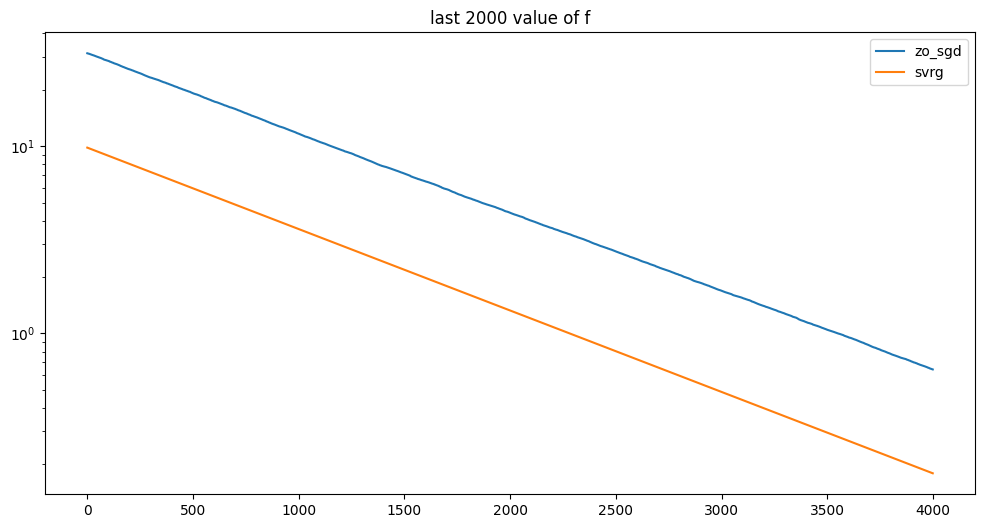

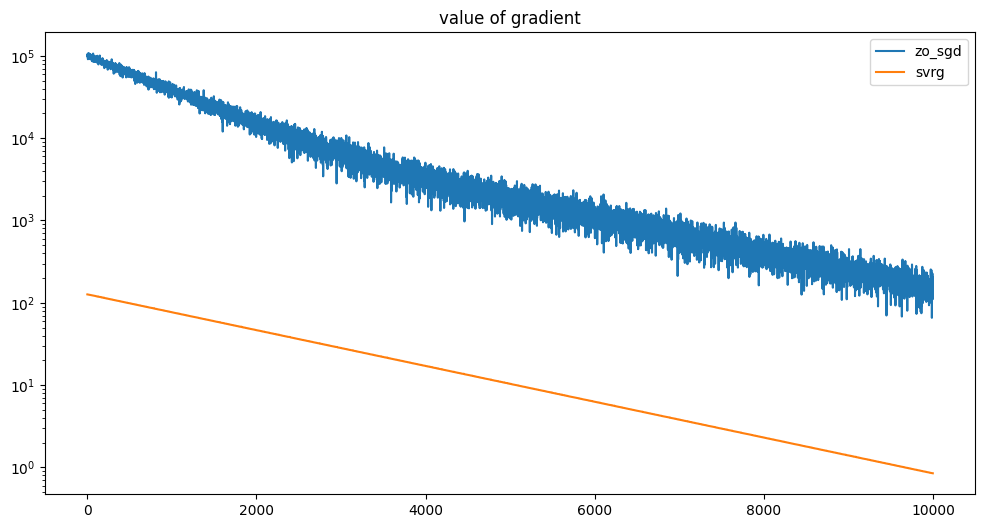

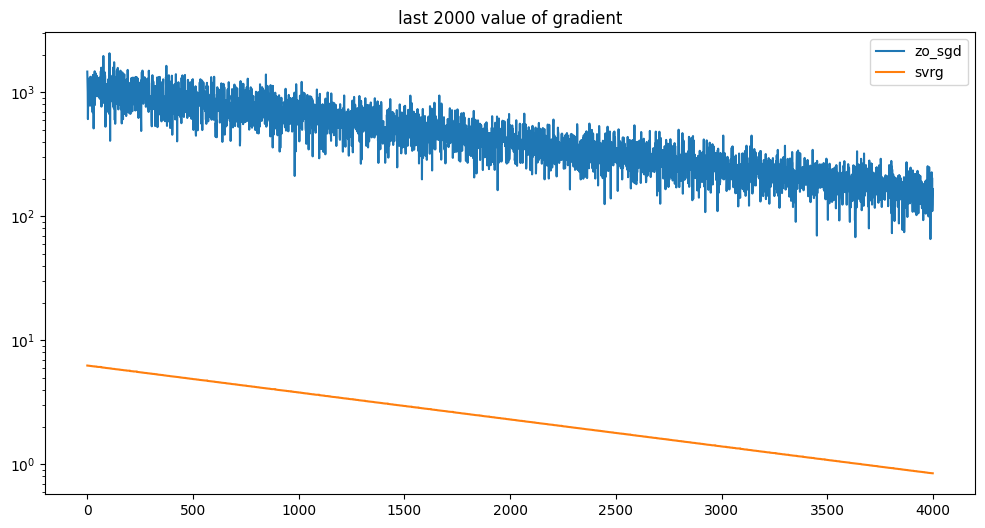

In [16]:
plt.figure(figsize=(12,6))
plt.title('value of f')
plt.plot(vf,label='zo_sgd')
plt.plot(vf_sgd,label='svrg')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.title('last 2000 value of f')
plt.plot(vf[6000:],label='zo_sgd')
plt.plot(vf_sgd[6000:],label='svrg')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.title('value of gradient')
plt.plot(vg,label='zo_sgd')
plt.plot(vg_sgd,label='svrg')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.title('last 2000 value of gradient')
plt.plot(vg[6000:],label='zo_sgd')
plt.plot(vg_sgd[6000:],label='svrg')
plt.yscale('log')
plt.legend()
plt.show()



## New $\mu_t$

In [17]:
def ZO_SGD_quad(T,gamma,X0,m):


    liste = np.zeros((T, d))
    value_f = np.zeros(T)
    value_grad = np.zeros(T)

    x0 = X0.copy()
    for t in range(T):
        v = np.random.choice(N,m,replace=False)

        mu0 = 1/((t+1)*2)
        grad_sum = np.zeros(d)
        for i in v:
            grad_sum += g_i(x0, i, mu0)


        x0 -= gamma * grad_sum / m


        liste[t, :] = x0
        value_f[t] = F(x0)
        value_grad[t] = np.linalg.norm(grad_sum)

    return liste,value_f,value_grad

def ZO_SGD_lin(T,gamma,X0,m):


    liste = np.zeros((T, d))
    value_f = np.zeros(T)
    value_grad = np.zeros(T)

    x0 = X0.copy()
    for t in range(T):
        v = np.random.choice(N,m,replace=False)
        # mu0 = max(np.exp(-(delta * t)), np.exp(-(delta * 600)))
        mu0 = 1/((t+1))
        grad_sum = np.zeros(d)
        for i in v:
            grad_sum += g_i(x0, i, mu0)


        x0 -= gamma * grad_sum / m



        liste[t, :] = x0
        value_f[t] = F(x0)
        value_grad[t] = np.linalg.norm(grad_sum)

    return liste,value_f,value_grad

def ZO_SGD_sublin(T,gamma,X0,m):


    liste = np.zeros((T, d))
    value_f = np.zeros(T)
    value_grad = np.zeros(T)

    x0 = X0.copy()
    for t in range(T):
        v = np.random.choice(N,m,replace=False)
        # mu0 = max(np.exp(-(delta * t)), np.exp(-(delta * 600)))
        mu0 = 1 / (1 + 0.01 * np.sqrt(t))

        grad_sum = np.zeros(d)
        for i in v:
            grad_sum += g_i(x0, i, mu0)


        x0 -= gamma * grad_sum / m


        liste[t, :] = x0
        value_f[t] = F(x0)
        value_grad[t] = np.linalg.norm(grad_sum)

    return liste,value_f,value_grad

Try for d =10

In [18]:
F, g_i, g_i_center,g_i_center_avg, gradF, N, a, d, x_star = function(d=10)

In [19]:
K=8000
m= 10
delta= 0.005
alpha= beta= L = 2

gamma = 0.5 * gamma_max(alpha, beta, L, d, N, m)
p=0.3
x0 = np.zeros(d)

vect_quad, vf_quad, vg_quad = ZO_SGD_quad(K, gamma, x0, m)
vect_lin, vf_lin, vg_lin = ZO_SGD_lin(K, gamma, x0, m)
vect_sublin, vf_sublin, vg_sublin = ZO_SGD_sublin(K, gamma, x0, m)
vect, vf, vg = ZO_SGD(K, gamma, delta, x0, m)
vect_SGD, vf_SGD, vg_SGD = SVRG(K,gamma,x0,m,p)

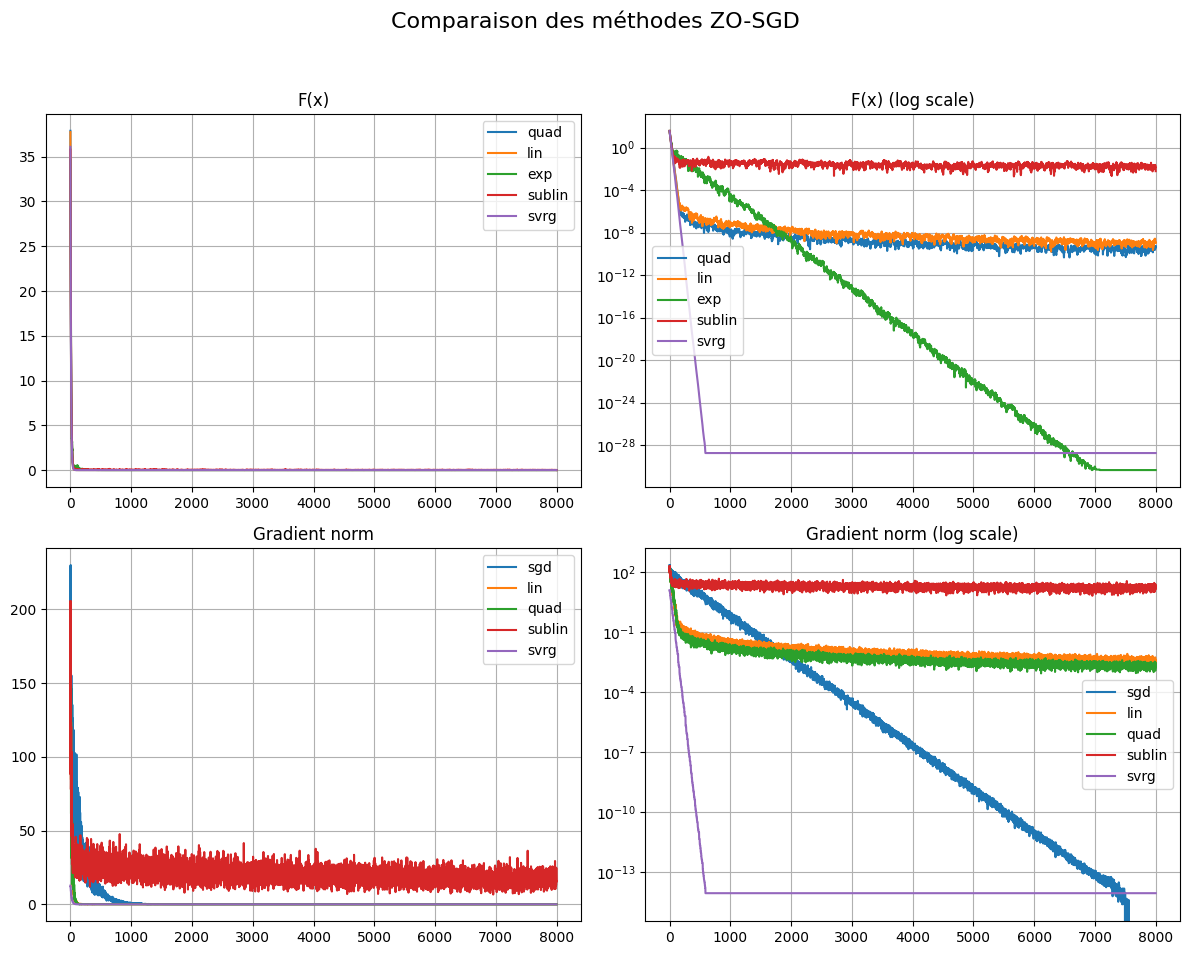

Erreur dernière itération       : 0.000000
Erreur moyenne derniers 3/4     : 0.000001
Erreur moyenne sur toutes       : 0.015646


In [20]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Comparaison des méthodes ZO-SGD', fontsize=16)


# vf_quad = vf_quad[3500:]
# vf_lin = vf_lin[3500:]
# vf = vf[3500:]
# vf_sublin = vf_sublin[3500:]
# vf_SGD = vf_SGD[3500:]

# Plot 1 — F(x)
axes[0, 0].set_title('F(x)')
axes[0, 0].plot(vf_quad, label='quad')
axes[0, 0].plot(vf_lin, label='lin')
axes[0, 0].plot(vf, label='exp')
axes[0, 0].plot(vf_sublin, label='sublin')
axes[0, 0].plot(vf_SGD, label='svrg')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot 2 — F(x) en log
axes[0, 1].set_title('F(x) (log scale)')
axes[0, 1].plot(vf_quad, label='quad')
axes[0, 1].plot(vf_lin, label='lin')
axes[0, 1].plot(vf, label='exp')
axes[0, 1].plot(vf_sublin, label='sublin')
axes[0, 1].plot(vf_SGD, label='svrg')
axes[0, 1].set_yscale('log')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot 3 — ||grad||
axes[1, 0].set_title('Gradient norm')
axes[1, 0].plot(vg, label='sgd')
axes[1, 0].plot(vg_lin, label='lin')
axes[1, 0].plot(vg_quad, label='quad')
axes[1, 0].plot(vg_sublin, label='sublin')
axes[1, 0].plot(vg_SGD, label='svrg')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot 4 — ||grad|| en log
axes[1, 1].set_title('Gradient norm (log scale)')
axes[1, 1].plot(vg, label='sgd')
axes[1, 1].plot(vg_lin, label='lin')
axes[1, 1].plot(vg_quad, label='quad')
axes[1, 1].plot(vg_sublin, label='sublin')
axes[1, 1].plot(vg_SGD, label='svrg')
axes[1, 1].set_yscale('log')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# 1. Optimum théorique (moyenne des a_i)
x_star = np.mean(a, axis=0)

# 2. Dernière itération
x_last = vect[-1]
error_last = np.linalg.norm(x_last - x_star)

# 3. Moyenne des 3/4 dernières itérations
x_mean_last_3q = np.mean(vect[int(len(vect) * 0.25):], axis=0)
error_mean_last_3q = np.linalg.norm(x_mean_last_3q - x_star)

# 4. Moyenne de toutes les itérations
x_mean_all = np.mean(vect, axis=0)
error_mean_all = np.linalg.norm(x_mean_all - x_star)

# 5. Affichage
print(f"Erreur dernière itération       : {error_last:.6f}")
print(f"Erreur moyenne derniers 3/4     : {error_mean_last_3q:.6f}")
print(f"Erreur moyenne sur toutes       : {error_mean_all:.6f}")


### New estimator

In [21]:
def function(N=2000, d=100, x_star_val=2.0):

    x_star = np.full(d, x_star_val)       # Minimiseur commun
    a = np.tile(x_star, (N, 1))           # Chaque a_i = x_star

    def F(x):
        return np.sum(np.abs(x - a) ** 2) / N  # Moyenne des f_i(x)

    def g_i_center(x, i, mu, q=1):
        grad = np.zeros_like(x)
        for _ in range(q):
            u = np.random.randn(d)
            u /= np.linalg.norm(u)
            f_plus = np.sum((x + mu * u - a[i]) ** 2)
            f_minus = np.sum((x - mu * u - a[i]) ** 2)
            grad += d * (f_plus - f_minus) * u / (2 * mu)
        return grad / q



    def g_i(x, i, mu):
        u = np.random.randn(d)
        u /= np.linalg.norm(u)
        fi_plus = np.sum((x + mu * u - a[i]) ** 2)
        fi = np.sum((x - a[i]) ** 2)
        return d * (fi_plus - fi) * u / mu

    def g_i_without_d(x, i, mu):
        u = np.random.randn(d)
        u /= np.linalg.norm(u)
        fi_plus = np.sum((x + mu * u - a[i]) ** 2)
        fi = np.sum((x - a[i]) ** 2)
        return  (fi_plus - fi) * u / mu


    def g_i_center_avg(x, i, mu, q):
        grad = np.zeros_like(x)
        for _ in range(q):
            u = np.random.randn(len(x))
            u /= np.linalg.norm(u)

            fi_plus = np.sum((x + mu * u - a[i]) ** 2)
            fi_minus = np.sum((x - mu * u - a[i]) ** 2)

            grad += d * (fi_plus - fi_minus) * u / (q * mu)

        return grad / q


    def gradF(x, v):
        return 2 * np.sum(x - a[v], axis=0) / len(v)

    return F, g_i, g_i_center,g_i_center_avg, g_i_without_d, gradF, N, a, d, x_star


In [22]:
F, g_i, g_i_center,g_i_center_avg,g_i_wd, gradF, N, a, d, x_star = function(d=10,x_star_val=9.0)

In [23]:
def ZO_SGD_new(T,gamma,delta,X0,m):
    liste = np.zeros((T, d))
    value_f = np.zeros(T)
    value_grad = np.zeros(T)

    x0 = X0.copy()
    for t in range(T):
        v = np.random.choice(N,m,replace=False)
        grad_sum = np.zeros(d)

        # mu0 = np.exp(-(delta * t))
        mu0= np.sqrt(d) * np.exp(-delta * t)

        for i in v:
            grad_sum += g_i_wd(x0, i, mu0)


        x0 -= gamma * grad_sum / m


        liste[t, :] = x0
        value_f[t] = F(x0)
        value_grad[t] = np.linalg.norm(grad_sum)
    return liste,value_f,value_grad

In [24]:
delta = 0.005
K=5000
m= 10
x0 = np.zeros(d)

gamma = 0.5 * gamma_max(alpha, beta, L, d, N, m)

p=0.3

vect, vf, vg = ZO_SGD(K, gamma, delta, x0, m)
vect_sgd,vf_sgd,vg_sgd = SVRG(K,gamma,x0,m,p)
vect_new, vf_new, vg_new = ZO_SGD_new(K, gamma, delta, x0, m)

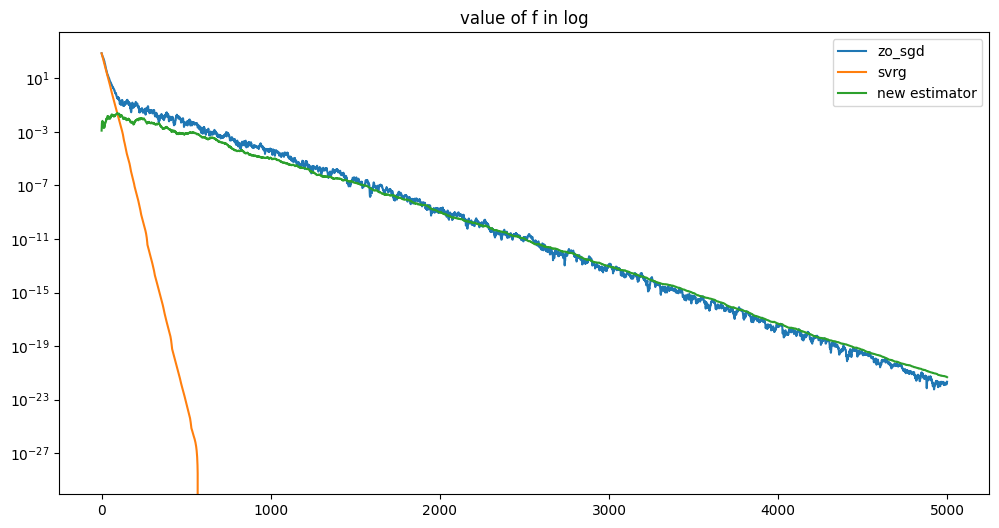

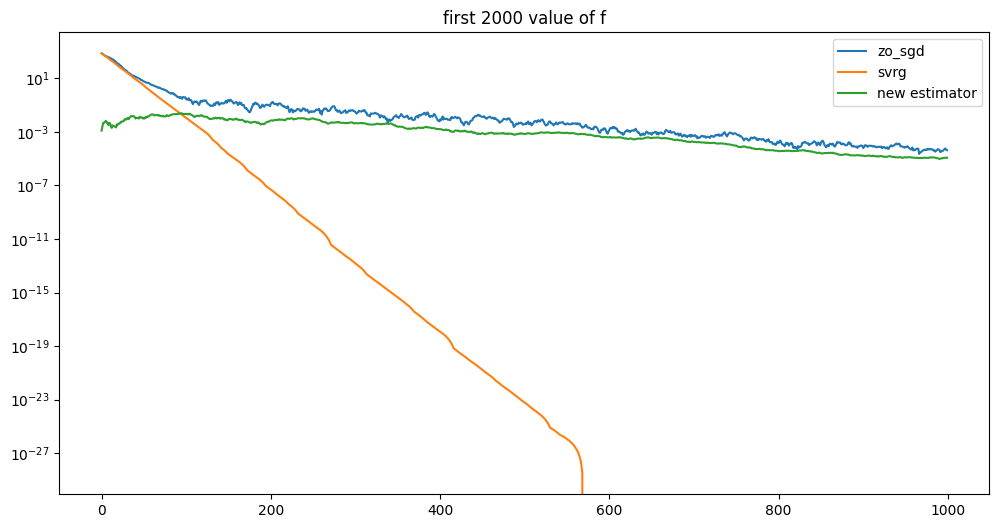

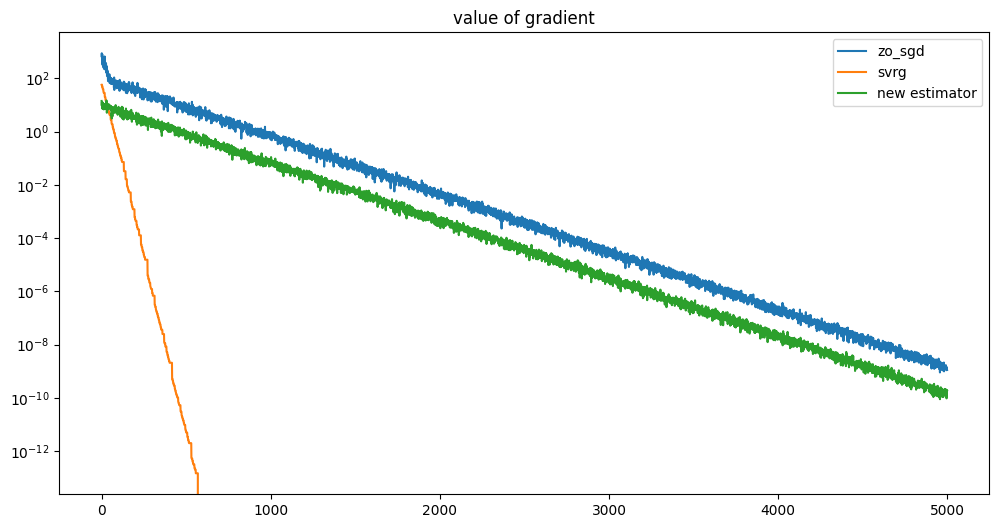

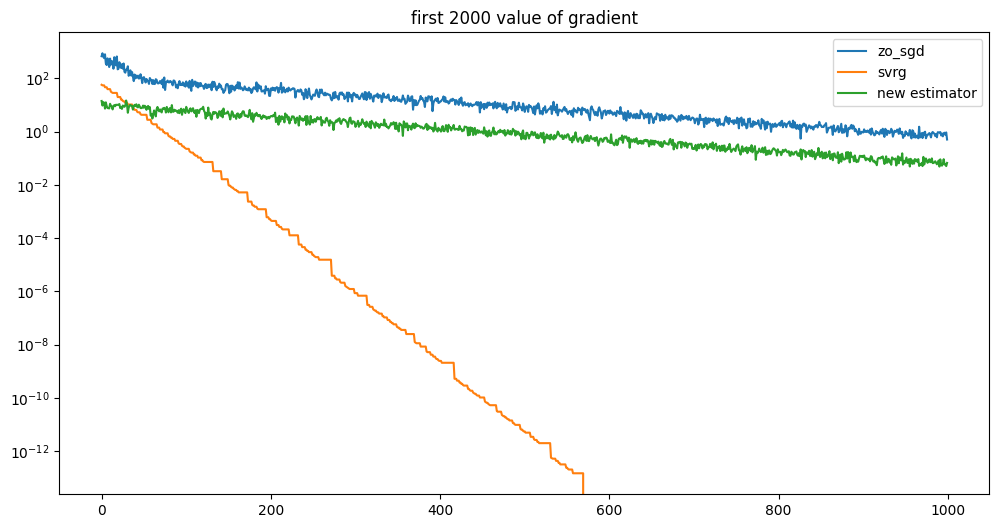

In [25]:
plt.figure(figsize=(12,6))
plt.title('value of f in log')
plt.plot(vf,label='zo_sgd')
plt.plot(vf_sgd,label='svrg')
plt.plot(vf_new,label='new estimator')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.title('first 2000 value of f')
plt.plot(vf[:1000],label='zo_sgd')
plt.plot(vf_sgd[:1000],label='svrg')
plt.plot(vf_new[:1000],label='new estimator')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.title('value of gradient')
plt.plot(vg,label='zo_sgd')
plt.plot(vg_sgd,label='svrg')
plt.plot(vg_new,label='new estimator')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.title('first 2000 value of gradient')
plt.plot(vg[:1000],label='zo_sgd')
plt.plot(vg_sgd[:1000],label='svrg')
plt.plot(vg_new[:1000],label='new estimator')
plt.yscale('log')
plt.legend()
plt.show()



Try with higher dimension

In [26]:
F, g_i, g_i_center,g_i_center_avg,g_i_wd, gradF, N, a, d, x_star = function(d=1000,x_star_val=9.0)

In [27]:
delta = 0.005
K=5000
m= 10
x0 = np.zeros(d)

gamma = 0.5 * gamma_max(alpha, beta, L, d, N, m)

p=0.3

vect, vf, vg = ZO_SGD(K, gamma, delta, x0, m)
vect_sgd,vf_sgd,vg_sgd = SVRG(K,gamma,x0,m,p)
vect_new, vf_new, vg_new = ZO_SGD_new(K, gamma, delta, x0, m)


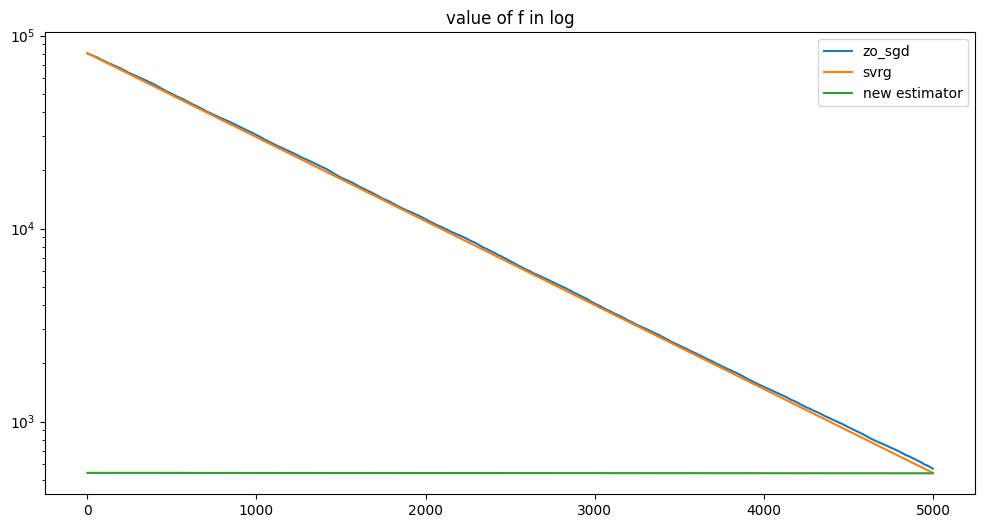

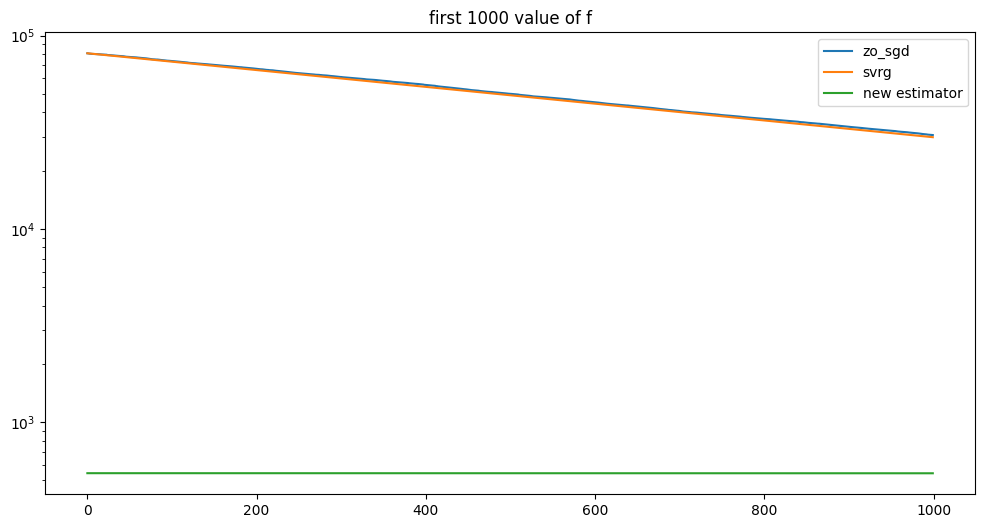

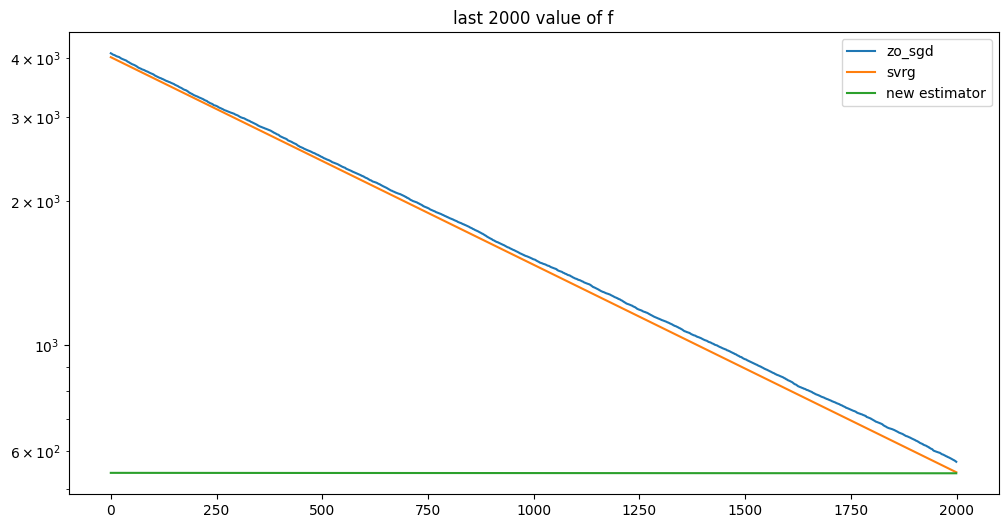

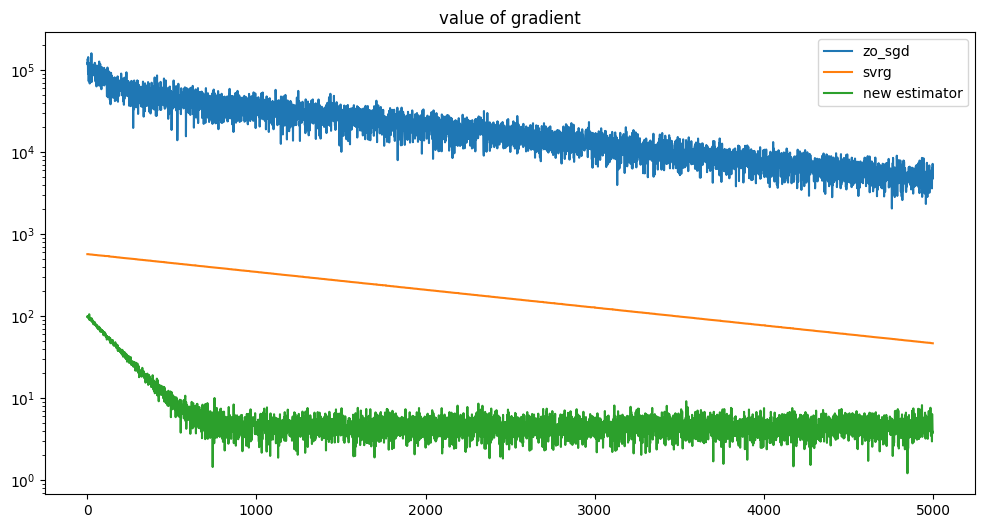

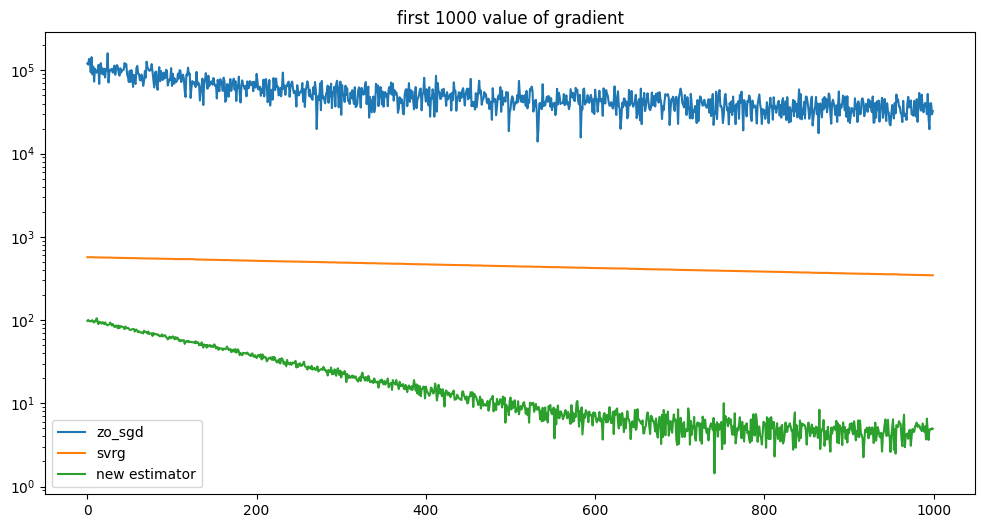

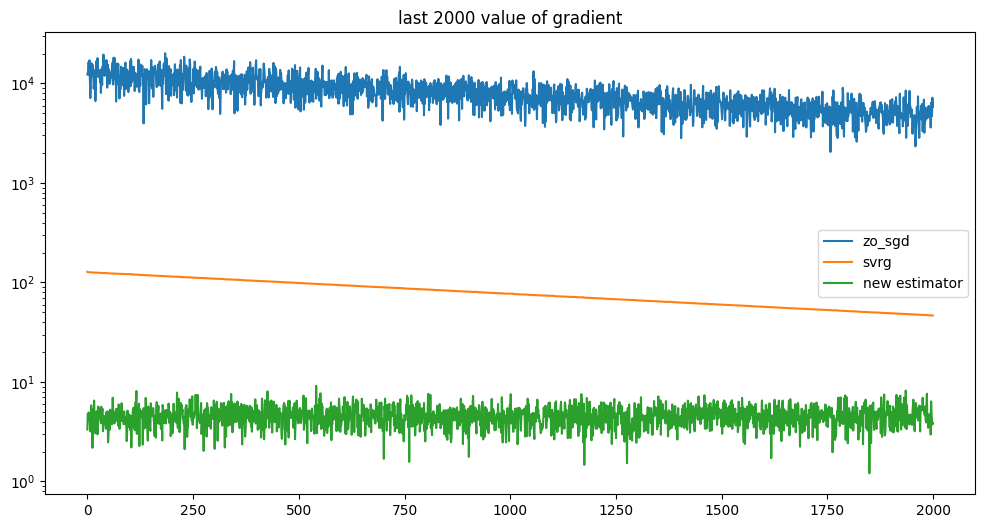

In [28]:

plt.figure(figsize=(12,6))
plt.title('value of f in log')
plt.plot(vf,label='zo_sgd')
plt.plot(vf_sgd,label='svrg')
plt.plot(vf_new,label='new estimator')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.title('first 1000 value of f')
plt.plot(vf[:1000],label='zo_sgd')
plt.plot(vf_sgd[:1000],label='svrg')
plt.plot(vf_new[:1000],label='new estimator')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.title('last 2000 value of f')
plt.plot(vf[3000:],label='zo_sgd')
plt.plot(vf_sgd[3000:],label='svrg')
plt.plot(vf_new[3000:],label='new estimator')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.title('value of gradient')
plt.plot(vg,label='zo_sgd')
plt.plot(vg_sgd,label='svrg')
plt.plot(vg_new,label='new estimator')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.title('first 1000 value of gradient')
plt.plot(vg[:1000],label='zo_sgd')
plt.plot(vg_sgd[:1000],label='svrg')
plt.plot(vg_new[:1000],label='new estimator')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.title('last 2000 value of gradient')
plt.plot(vg[3000:],label='zo_sgd')
plt.plot(vg_sgd[3000:],label='svrg')
plt.plot(vg_new[3000:],label='new estimator')
plt.yscale('log')
plt.legend()
plt.show()

### Runtime check

In [29]:
import time

In [30]:
def SVRG_time(x0, gamma, m, p, max_time):
    liste = []
    value_f = []
    value_grad = []
    start_time = time.time()
    elapsed_time = 0
    liste_time = []


    w0 = x0
    gradw0 = gradF(w0, np.arange(N))

    while elapsed_time < max_time:
        v = np.random.choice(N,m,replace=False)

        g1 = gradw0 + gradF(x0,v) - gradF(w0, v)
        x1 = x0 - gamma * g1
        x0 = x1

        proba = np.random.rand()

        if proba < p :

            w0 = x0
            gradw0 = gradF(w0, np.arange(N))

        liste.append(x0)
        value_f.append(F(x0))
        value_grad.append(np.linalg.norm(g1))
        liste_time.append(elapsed_time)
        elapsed_time = time.time() - start_time

    return liste,value_f,value_grad, liste_time


def ZO_SGD_time(gamma,delta,x0,m,max_time):
    liste = []
    value_f = []
    value_grad = []
    start_time = time.time()
    elapsed_time = 0
    liste_time = []

    iteration = 0

    while elapsed_time < max_time:
        v = np.random.choice(N,m,replace=False)
        grad_sum = np.zeros(d)

        # mu0 = np.exp(-(delta * t))
        mu0= np.sqrt(d) *np.exp(-delta * iteration)

        for i in v:
            grad_sum += g_i(x0, i, mu0)


        x0 -= gamma * grad_sum / m


        liste.append(x0)
        value_f.append(F(x0))
        value_grad.append(np.linalg.norm(grad_sum / m))
        liste_time.append(elapsed_time)
        iteration += 1
        elapsed_time = time.time() - start_time

    return liste,value_f,value_grad, liste_time




In [31]:
delta = 0.005
max_time = 30
m= 1
x0 = np.zeros(d)

gamma = 0.5 * gamma_max(alpha, beta, L, d, N, m)

p=0.3

vect_sgd_time, vf_sgd_time, vg_sgd_time,time_sgd_time = ZO_SGD_time(gamma, delta, x0, m, max_time)
vect_svrg_time,vf_svrg_time,vg_svrg_time,timetime = SVRG_time(x0, gamma, m, p, max_time)

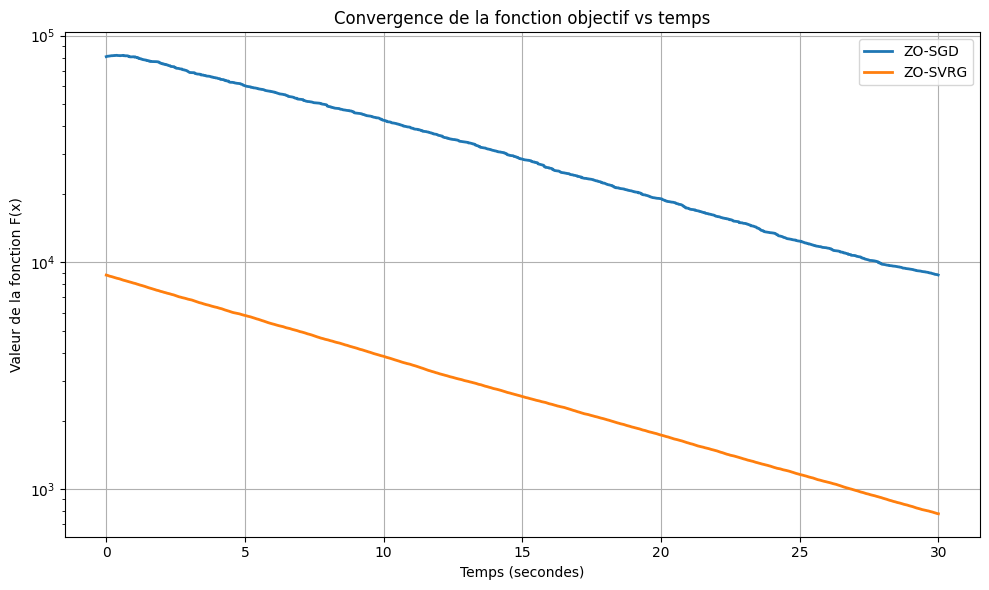

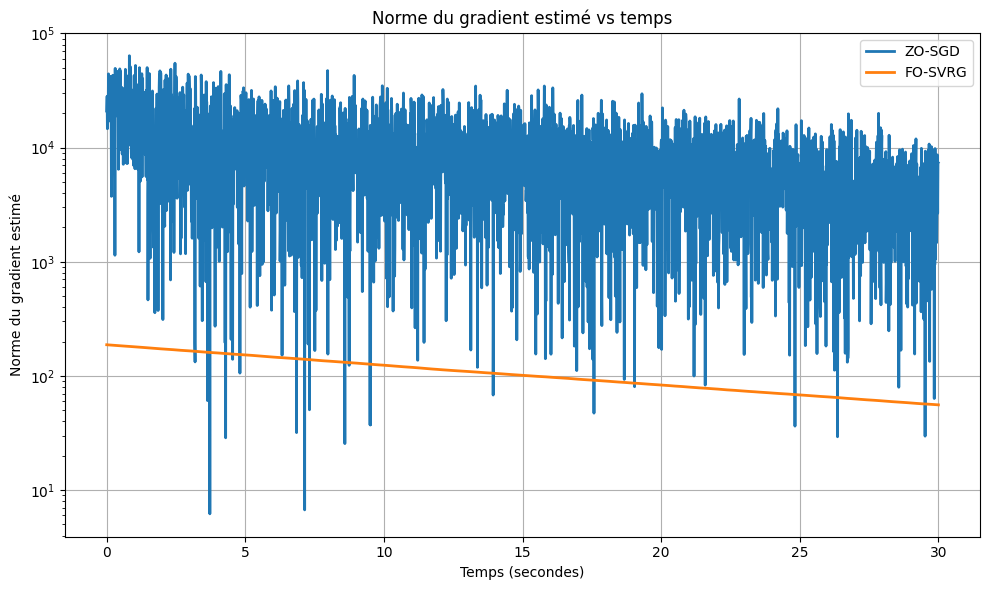

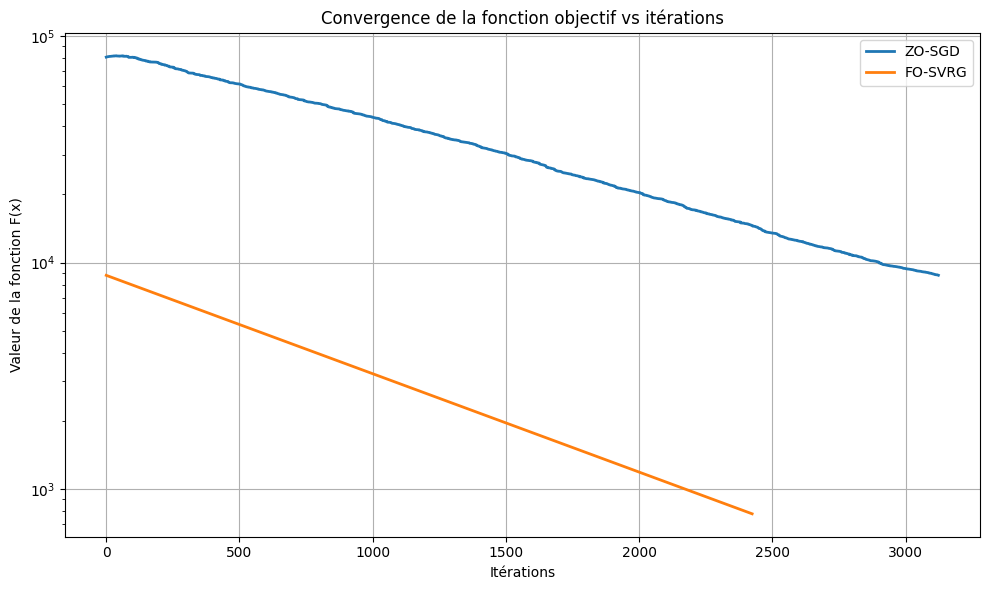

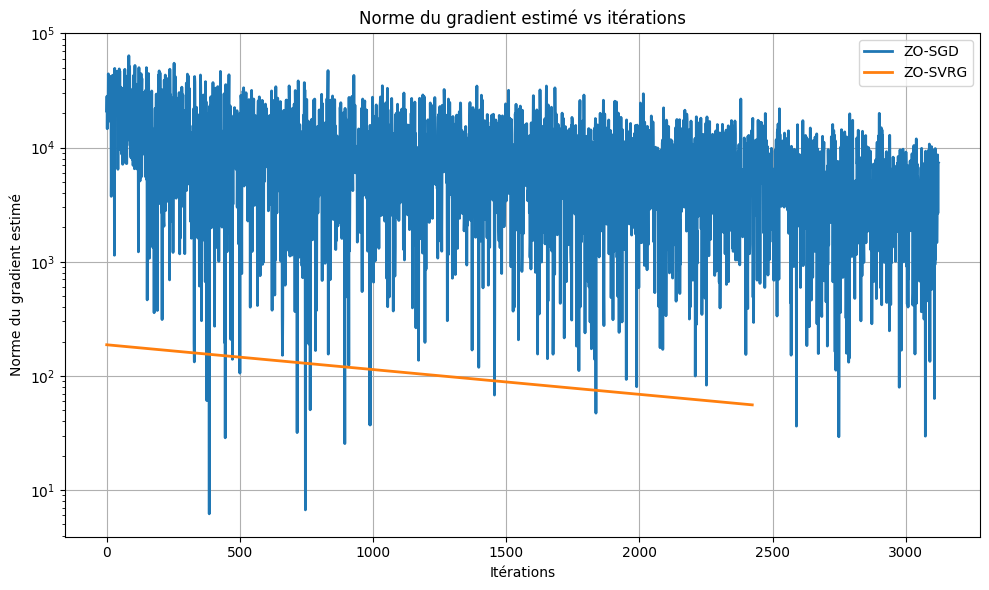

In [32]:
it_sgd_time = np.arange(len(vf_sgd_time))
it_svrg_time = np.arange(len(vf_svrg_time))


plt.figure(figsize=(10, 6))
plt.plot(time_sgd_time, vf_sgd_time, label='ZO-SGD', linewidth=2)
plt.plot(timetime, vf_svrg_time, label='ZO-SVRG', linewidth=2)
plt.yscale('log')
plt.xlabel("Temps (secondes)")
plt.ylabel("Valeur de la fonction F(x)")
plt.title("Convergence de la fonction objectif vs temps")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Courbe de convergence : norme du gradient estimé (vg)
plt.figure(figsize=(10, 6))
plt.plot(time_sgd_time, vg_sgd_time, label='ZO-SGD', linewidth=2)
plt.plot(timetime, vg_svrg_time, label='FO-SVRG', linewidth=2)
plt.yscale('log')
plt.xlabel("Temps (secondes)")
plt.ylabel("Norme du gradient estimé")
plt.title("Norme du gradient estimé vs temps")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(it_sgd_time, vf_sgd_time, label='ZO-SGD', linewidth=2)
plt.plot(it_svrg_time, vf_svrg_time, label='FO-SVRG', linewidth=2)
plt.yscale('log')
plt.xlabel("Itérations")
plt.ylabel("Valeur de la fonction F(x)")
plt.title("Convergence de la fonction objectif vs itérations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Courbe de convergence : norme du gradient estimé (vg) vs itérations
plt.figure(figsize=(10, 6))
plt.plot(it_sgd_time, vg_sgd_time, label='ZO-SGD', linewidth=2)
plt.plot(it_svrg_time, vg_svrg_time, label='ZO-SVRG', linewidth=2)
plt.yscale('log')
plt.xlabel("Itérations")
plt.ylabel("Norme du gradient estimé")
plt.title("Norme du gradient estimé vs itérations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
batch_size = [1, 10, 25, 50, 100, 250, 500, 1000, 1500, N]
all_vf = {}

delta = 0.005
max_time = 30

gamma = 0.5 * gamma_max(alpha, beta, L, d, N, m)

p=0.3

for k, m in enumerate(batch_size):
    x0 = np.zeros(d)
    vect_sgd_time, vf_sgd_time, vg_sgd_time,time_sgd_time = ZO_SGD_time(gamma, delta, x0, m, max_time)
    key = f"m={m}"
    it_sgd_time = np.arange(len(vf_sgd_time))
    all_vf[key] = vf_sgd_time,vg_sgd_time, it_sgd_time, time_sgd_time

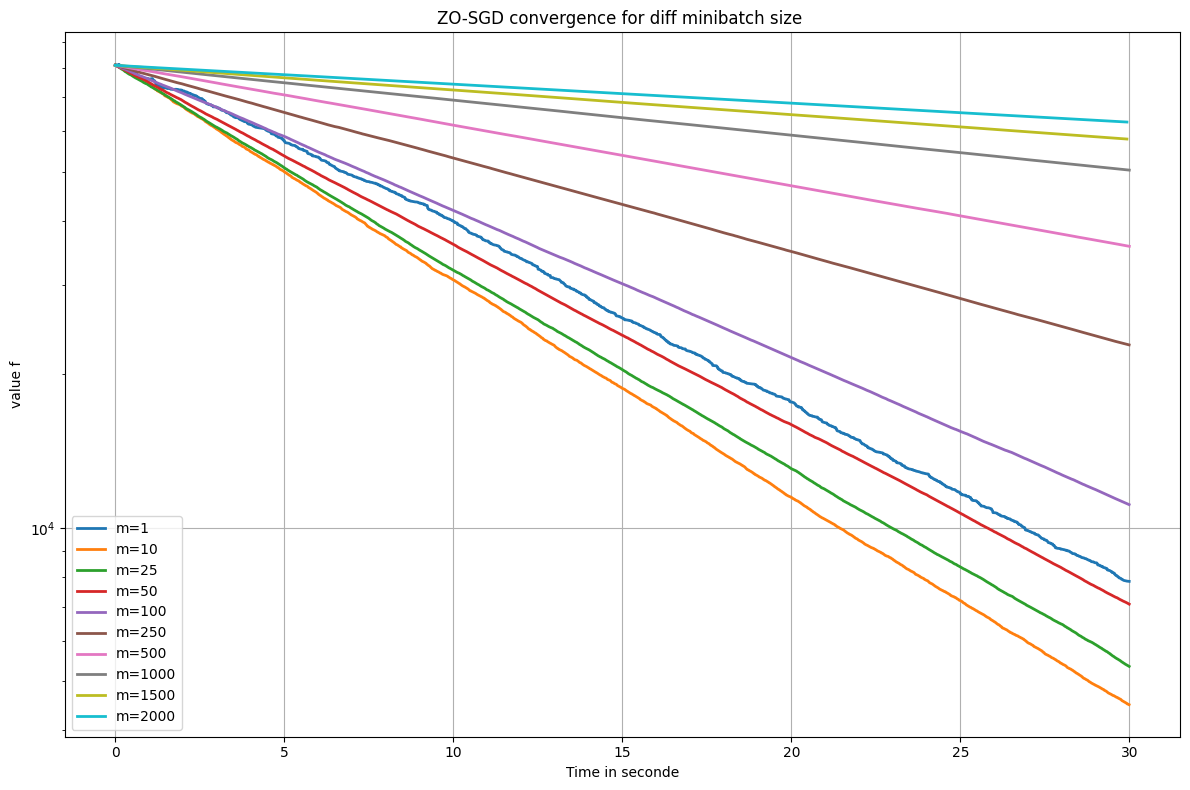

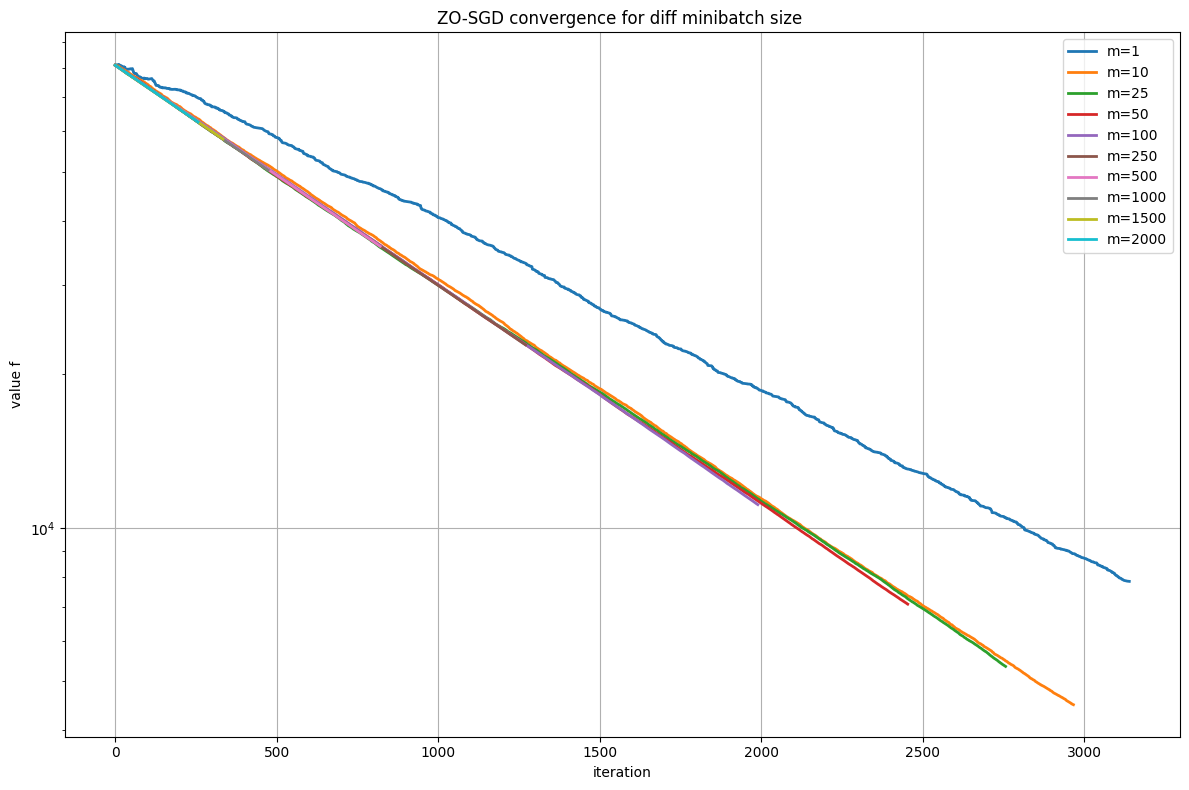

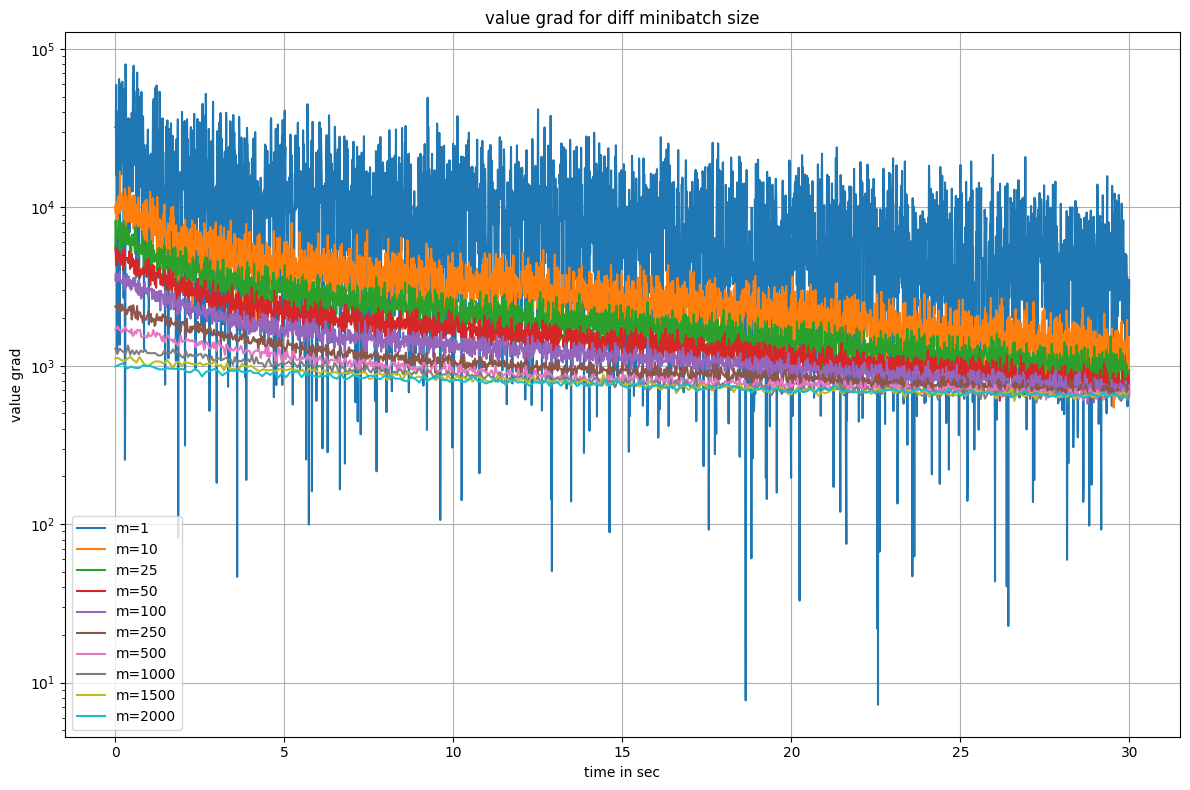

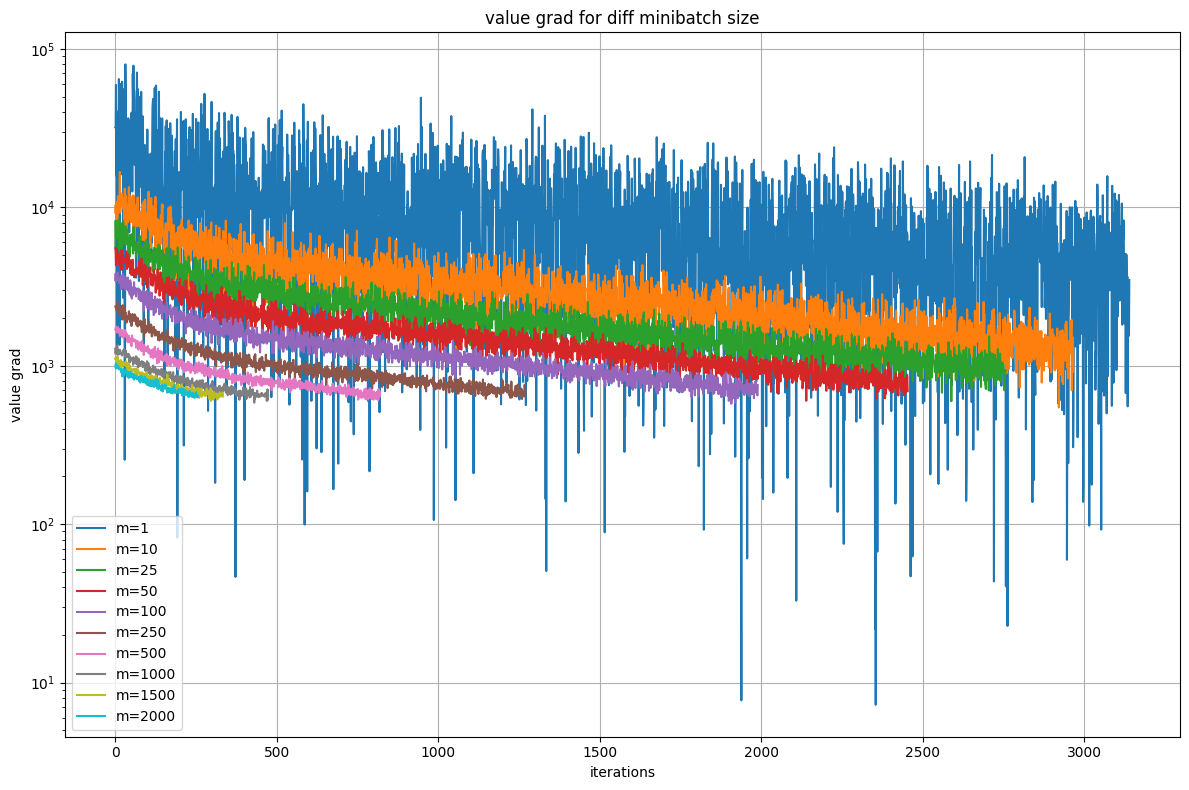

In [34]:
plt.figure(figsize=(12, 8))

for key, (vf_sgd_time, vg_sgd_time, it_sgd_time, time_sgd_time) in all_vf.items():
    plt.plot(time_sgd_time, vf_sgd_time, label=key, linewidth=2)

plt.title("ZO-SGD convergence for diff minibatch size ")
plt.xlabel("Time in seconde")
plt.ylabel("value f")
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))

for key, (vf_sgd_time, vg_sgd_time, it_sgd_time, time_sgd_time) in all_vf.items():
    plt.plot(it_sgd_time, vf_sgd_time, label=key, linewidth=2)

plt.title("ZO-SGD convergence for diff minibatch size ")
plt.xlabel("iteration")
plt.ylabel("value f")
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 8))

for key, (vf_sgd_time, vg_sgd_time, it_sgd_time, time_sgd_time) in all_vf.items():
    plt.plot(time_sgd_time, vg_sgd_time, label=key)

plt.title("value grad for diff minibatch size")
plt.xlabel("time in sec")
plt.ylabel("value grad")
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))

for key, (vf_sgd_time, vg_sgd_time, it_sgd_time, time_sgd_time) in all_vf.items():
    plt.plot(it_sgd_time,vg_sgd_time, label=key)

plt.title("value grad for diff minibatch size")
plt.xlabel("iterations")
plt.ylabel("value grad")
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.tight_layout()
plt.show()